In [9]:
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torchvision import transforms

In [10]:
data_dir = '../data/gray_formatted/'
batch_size = 8
n_workers = 4
n_epochs = 50
lr = 0.001
img_dim = 64

In [11]:
def input_transform(img):
    img = np.array(img)
    target, outline = np.split(img, 2, axis=1)
    target = transforms.ToTensor()(target)
    outline = transforms.ToTensor()(outline)
    return outline, target

In [12]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=input_transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=n_workers)

def get_generator():
    data_iter = iter(dataloader)
    for (X, y), _ in data_iter:
        yield X, y

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 3 x 64 x 64 input
        
        # Downscale
        self.ds1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.dropout(0.4))
        self.ds2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.ds3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.dropout(0.4))
        
        # Upscale
        self.us1 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.ReLU())
        self.us2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.ReLU(),
            nn.dropout(0.4))
        self.us3 = nn.Sequential(
            nn.Conv2d(8, 3, kernel_size=5, stride=1, padding=2),
            nn.Upsample(scale_factor=2))
        
        self.detail = nn.Conv2d(3, 3, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        # Downscale
        z1 = self.ds1(x)
        z2 = self.ds2(z1)
        z3 = self.ds3(z2)
        
        z4 = self.us1(z3) + z2
        z5 = self.us2(z4) + z1
        z6 = self.us3(z5) + x
        
        raw = self.detail(z6)
        
        out = torch.clamp(raw, 0, 1)
        
        return out

def calc_loss(y_pred, y):
    loss = (y_pred - y)**2
    loss = loss.view(-1)
    loss = torch.sum(loss)
    
    return loss

In [43]:
model = CNN().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
losses = []

for epoch in range(n_epochs):
    print(f'Starting epoch #{epoch+1}')
    
    data_gen = get_generator()
    for step, (X, y) in enumerate(data_gen):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(X)
        loss = calc_loss(y_pred, y)
        losses.append(loss.detach().numpy())

        if step > 0 and step % 500 == 0:
            print(f'Step #{step} loss: {np.mean(losses[-1000:])}')

        loss.backward()
        optimizer.step()

Starting epoch #1
Step #500 loss: 7154.59326171875
Step #1000 loss: 5480.2900390625
Step #1500 loss: 3643.39501953125
Step #2000 loss: 3314.94580078125
Step #2500 loss: 3133.24462890625
Starting epoch #2
Step #500 loss: 2990.8935546875
Step #1000 loss: 2907.0849609375
Step #1500 loss: 2842.596435546875
Step #2000 loss: 2800.74072265625
Step #2500 loss: 2779.931396484375
Starting epoch #3
Step #500 loss: 2721.52734375
Step #1000 loss: 2675.456298828125
Step #1500 loss: 2649.017333984375
Step #2000 loss: 2622.22412109375
Step #2500 loss: 2575.45849609375
Starting epoch #4
Step #500 loss: 2558.51171875
Step #1000 loss: 2540.2919921875
Step #1500 loss: 2524.85498046875
Step #2000 loss: 2518.50048828125
Step #2500 loss: 2491.623046875
Starting epoch #5
Step #500 loss: 2479.952392578125
Step #1000 loss: 2455.441650390625
Step #1500 loss: 2439.087158203125
Step #2000 loss: 2448.477294921875
Step #2500 loss: 2445.56103515625
Starting epoch #6
Step #500 loss: 2423.591552734375
Step #1000 loss: 

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


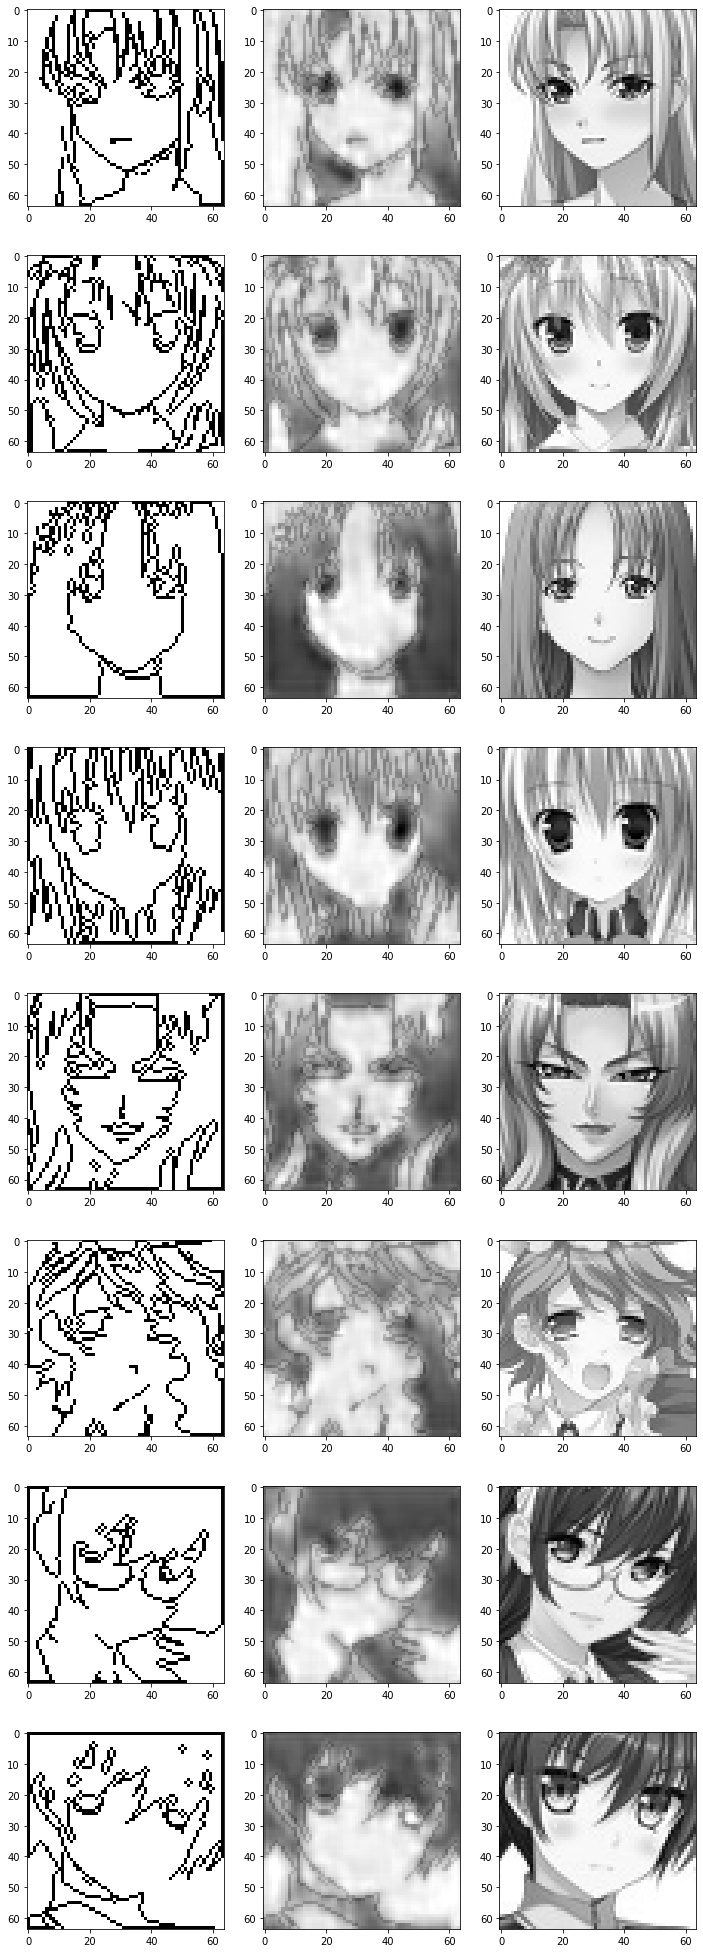

In [69]:
model.eval()
data_gen = get_generator()
X, y = next(data_gen)

example_imgs = []

for i in range(batch_size):
    outline = X[i].transpose(0, 1).transpose(1, 2).detach().numpy()
    img = model(X[i:i+1]).squeeze().transpose(0, 1).transpose(1, 2).detach().numpy()
    actual = y[i].transpose(0, 1).transpose(1, 2).detach().numpy()
    
    example_imgs.append(outline)
    example_imgs.append(img)
    example_imgs.append(actual)

plt.figure(figsize=(12, batch_size * 5))
columns = 3
for i, img in enumerate(example_imgs):
    plt.subplot(len(example_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img)